# Load processed datasets
From datasets.ipynb

In [1]:
import pickle

path = '/storage2/mamille3/hegemonic_hate/tmp/processed_datasets.pkl'
with open(path, 'rb') as f:
    hate_datasets = pickle.load(f)
hate_datasets.keys()

dict_keys(['cad', 'elsherief2021', 'sbic', 'kennedy2020', 'salminen2018'])

# Form, split datasets
Output: train, dev and test folds for with-hegemonic and no-hegemonic splits. All splits/folds have 30/70 hate/no-hate ratios

In [13]:
from collections import Counter
import pandas as pd
import pdb
from tqdm.notebook import tqdm

diffs = [] # for later visualization
# for dataset in sorted(hate_datasets)[4:5]:
for dataset in tqdm(sorted(hate_datasets)):
    print(dataset)

    # Remove instances with hegemonic labels
    # print(len(hate_datasets[dataset]))
    # print(hate_datasets[dataset].group_label.unique())
    no_hegemonic = hate_datasets[dataset].query('group_label != "hegemonic"')
    # print(len(no_hegemonic))
    # print(no_hegemonic.group_label.unique())

    # Sample to specific ratios of hate/nonhate
    hate_ratio = 0.30

    # Desired sampling of non-hate. Keep all hate rows (for no_hegemonic since that's the smallest set)
    n_hate = no_hegemonic.hate.sum()
    # print(n_hate)
    n_samples = {
        True: n_hate,
        False: int((n_hate*(1-hate_ratio))/hate_ratio)
    }
    # print(n_samples)
    # print(no_hegemonic.hate.value_counts())
    
    def get_n_samples(x):
        """ Get number of samples for a dataset split """
        desired_n = n_samples[x.name]
        if desired_n > sum(x.hate==x.name): # if there are more rows needed than are present
            return x.sample(desired_n, random_state=9, replace=True) # upsample nonhate
        else:
            return x.sample(desired_n, random_state=9, replace=False)

    resampled_no_heg = no_hegemonic.groupby('hate').apply(get_n_samples)
    resampled_no_heg.index = resampled_no_heg.index.droplevel('hate')
    resampled_no_heg = resampled_no_heg.sample(frac=1, random_state=9)
    # print(resampled_no_heg.hate.value_counts())
    # print(resampled_no_heg.hate.value_counts(normalize=True))
    # print(resampled_no_heg.group_label.value_counts())
    # n_samples

    # Sample with_hegemonic dataset
    # Want to preserve all the hegemonic instances (hate or non-hate) for maximum differences between datasets.
    # So take them out first, then add them back in
    # Want to make this exactly the same as no_hegemonic, but with hegemonic instances replacing others
    hegemonic_hate = hate_datasets[dataset].query('hate and group_label=="hegemonic"')
    # n_samples[True] = n_hate-len(hegemonic_hate)
    hegemonic_nonhate = hate_datasets[dataset].query('(not hate) and (group_label=="hegemonic")')
    # n_samples[False] = n_samples[False]-len(hegemonic_nonhate)
    # no_hegemonic_hate = hate_datasets[dataset].query('not (hate and group_label=="hegemonic")')
    # n_samples[True] = n_hate-len(hegemonic_hate)
    # no_hegemonic_hate = hate_datasets[dataset].query('not (hate and group_label=="hegemonic")')
    # resampled_with_heg = no_hegemonic_hate.groupby('hate').apply(lambda x: x.sample(n_samples[x.name]))
    n_nonhate = len(resampled_no_heg.query('not hate'))
    desired_n_hegemonic_nonhate = int(len(hegemonic_nonhate)/len(hate_datasets[dataset].query('not hate')) * n_samples[False]) # match ratio overall in the dataset
    replacement = False
    if desired_n_hegemonic_nonhate > len(hegemonic_nonhate): # have oversampled nonhate and some nonhate is labeled hegemonic
        replacement = True
    resampled_with_heg = pd.concat([resampled_no_heg.query('hate').sample(n_hate-len(hegemonic_hate)), 
                                    hegemonic_hate,
                                    resampled_no_heg.query('not hate').sample(n_samples[False] - desired_n_hegemonic_nonhate),
                                    hegemonic_nonhate.sample(desired_n_hegemonic_nonhate, replace=replacement)
                                   ], axis=0)
    
    # resampled_with_heg = no_hegemonic_hate.groupby('hate').apply(get_n_samples)
    # resampled_with_heg.index = resampled_with_heg.index.droplevel('hate')
    # resampled_with_heg = pd.concat([resampled_with_heg, hegemonic_hate], axis=0) # add hegemonic back in
    resampled_with_heg = resampled_with_heg.sample(frac=1, random_state=9)
    # print(resampled_with_heg.hate.value_counts())
    # print(resampled_with_heg.hate.value_counts(normalize=True))
    # print(resampled_with_heg.group_label.value_counts())

    # Test overlap between with_heg and no_heg to see if it's maximum that it can be
    # Should be exact overlap on not hate that's not hegemonic
    # print(len(resampled_with_heg))
    # print(len(resampled_no_heg))
    # intersection = set(resampled_with_heg.index).intersection(set(resampled_no_heg.index))
    unique_heg = Counter(resampled_with_heg.index) - Counter(resampled_no_heg.index)
    assert sum(unique_heg.values()) == len(hegemonic_hate) + desired_n_hegemonic_nonhate
    # intersection = sorted(resampled_with_heg.index.tolist()) -
    # assert (len(resampled_with_heg.index.drop_duplicates()) - len(intersection)) == (len(hegemonic_hate) + desired_n_hegemonic_nonhate)
    # print(len(intersection))
    # print(len(hegemonic_hate))
    # with_heg_nonhate = resampled_with_heg.query('not hate')
    # no_heg_nonhate = resampled_no_heg.query('not hate')
    # # print(len(with_heg_nonhate))
    # # print(len(no_heg_nonhate))
    # nonhate_intersection = pd.merge(with_heg_nonhate, no_heg_nonhate) 
    # assert len(with_heg_nonhate) == len(no_heg_nonhate) == len(nonhate_intersection)

    # Split into train/dev/test 60/10/30
    import numpy as np
    
    # Get, print differences between with-heg vs no-heg splits (can use indexes)
    inds = {'overlap': {}, 'with_heg_diff': {}, 'no_heg_diff': {}}
    inds['overlap']['all'] = set(resampled_with_heg.index).intersection(set(resampled_no_heg.index))
    inds['with_heg_diff']['all'] = set(resampled_with_heg.index) - inds['overlap']['all']
    inds['no_heg_diff']['all'] = set(resampled_no_heg.index) - inds['overlap']['all']

    # To make splits as similar as possible, split overlap and diffs separately and distribute among the folds
    # Splitting unique indices so even if nonhate in datasets were oversampled, 
    for split in inds:
        inds[split]['train'], inds[split]['dev'], inds[split]['test'] = np.split(list(inds[split]['all']), [int(0.6*len(inds[split]['all'])), int(0.7*len(inds[split]['all']))])
    # with_heg['train'], with_heg['dev'], with_heg['test'] = np.split(resampled_with_heg, [int(0.6*len(resampled_with_heg)), int(0.7*len(resampled_with_heg))])
    # no_heg['train'], no_heg['dev'], no_heg['test'] = np.split(resampled_no_heg, [int(0.6*len(resampled_no_heg)), int(0.7*len(resampled_no_heg))])

    with_heg, no_heg = {}, {}
    for fold in ['train', 'dev', 'test']:
        with_heg[fold] = resampled_with_heg[resampled_with_heg.index.isin(inds['overlap'][fold]) | resampled_with_heg.index.isin(inds['with_heg_diff'][fold])]
        with_heg[fold].sample(frac=1)
        no_heg[fold] = resampled_no_heg[resampled_no_heg.index.isin(inds['overlap'][fold]) | resampled_no_heg.index.isin(inds['no_heg_diff'][fold])]
        no_heg[fold].sample(frac=1)
    
    print('with_heg')
    for name, fold in with_heg.items():
        print(f'{name}: {len(fold)} instances')
        print(fold.group_label.value_counts())
        print(fold.hate.value_counts(normalize=True))
        # Test hate ratio
        print()
    # print('no_heg')
    # for name, fold in no_heg.items():
    #     print(f'{name}: {len(fold)} instances')
    #     print(fold.group_label.value_counts())
    
    # Train/dev/test differences
    split_diffs = {'dataset': dataset, 'absolute': len(resampled_with_heg[resampled_with_heg.index.isin(inds['with_heg_diff']['all'])])}
    split_diffs['percentage'] = split_diffs['absolute']/len(resampled_with_heg)
    diffs.append(split_diffs)
    print(f"Overall number of instances different between with-heg and no-heg: {split_diffs['absolute']} ({split_diffs['percentage']:.1%})")
    for name in with_heg:
        overlap = set(with_heg[name].index).intersection(set(no_heg[name].index))
        diff = set(with_heg[name].index) - overlap
        print(f"\t{name} number of instances different: {len(diff)} ({len(diff)/len(with_heg[name]):.1%})")
    
    print()
    print('********************************************')

    # Save out
    # Just do /tmp for now, but when I settle on which splits are important, then save out to csvs in hate_speech/<dataset>
    outpath = f'/storage2/mamille3/hegemonic_hate/tmp/{dataset}_hegsplits_{hate_ratio}hate.pkl'
    with open(outpath, 'wb') as f:
        pickle.dump({'with_heg': with_heg, 'no_heg': no_heg}, f)

  0%|          | 0/5 [00:00<?, ?it/s]

cad
with_heg
train: 7587 instances
marginalized    1277
other            847
hegemonic        187
Name: group_label, dtype: int64
False    0.6954
True     0.3046
Name: hate, dtype: float64

dev: 1264 instances
marginalized    192
other           144
hegemonic        31
Name: group_label, dtype: int64
False    0.709652
True     0.290348
Name: hate, dtype: float64

test: 3795 instances
marginalized    627
other           395
hegemonic        94
Name: group_label, dtype: int64
False    0.705929
True     0.294071
Name: hate, dtype: float64

Overall number of instances different between with-heg and no-heg: 312 (2.5%)
	train number of instances different: 187 (2.5%)
	dev number of instances different: 31 (2.5%)
	test number of instances different: 94 (2.5%)

********************************************
elsherief2021
with_heg
train: 10393 instances
marginalized    3161
other            875
hegemonic        696
Name: group_label, dtype: int64
False    0.544694
True     0.455306
Name: hate, dt

,dataset,absolute,percentage
0,cad,312,0.024672
1,elsherief2021,1161,0.067021
2,kennedy2020,6223,0.377083
3,salminen2018,494,0.079256
4,sbic,526,0.007698


# Visualize differences between splits

In [18]:
diffs_df = pd.DataFrame(diffs).set_index('dataset').sort_values('absolute')
diffs_df

,absolute,percentage
dataset,,
cad,312,0.024672
salminen2018,494,0.079256
sbic,526,0.007698
elsherief2021,1161,0.067021
kennedy2020,6223,0.377083


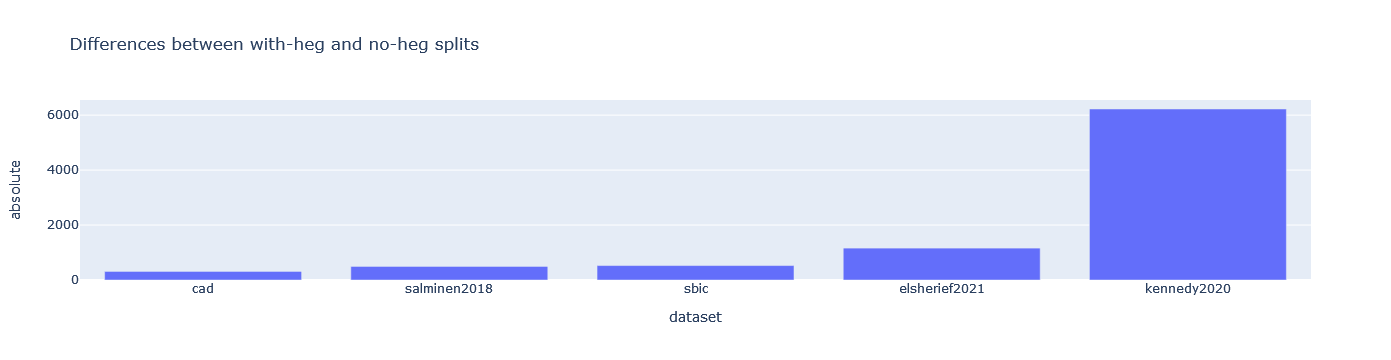

In [22]:
import plotly.express as px

px.bar(diffs_df, x=diffs_df.index, y='absolute', title='Differences between with-heg and no-heg splits')

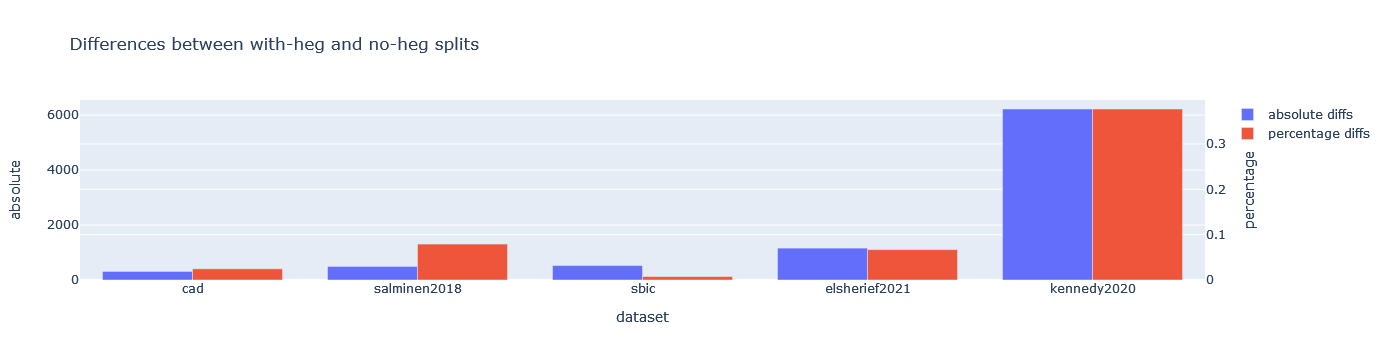

In [35]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = go.Figure(
    data=[
        go.Bar(x=diffs_df.index, y=diffs_df.absolute, yaxis='y', offsetgroup=1, name='absolute diffs'),
        go.Bar(x=diffs_df.index, y=diffs_df.percentage, yaxis='y2', offsetgroup=2, name='percentage diffs'),
    ],
    layout={
        'yaxis': {'title': 'absolute'},
        'yaxis2': {'title': 'percentage', 'overlaying': 'y', 'side': 'right'},
    }
)

fig.update_xaxes(title_text='dataset')

# fig = make_subplots(specs=[[{'secondary_y': True}]])

# fig.add_trace(
#     go.Bar(x=diffs_df.index, y=diffs_df.absolute),
#     secondary_y=False
# )

# fig.add_trace(
#     go.Bar(x=diffs_df.index, y=diffs_df.percentage),
#     secondary_y=True
# )

# fig.update_layout(title_text='Differences between with-heg and no-heg splits')
# fig.update_xaxes(title_text='dataset')
# fig.update_yaxes(title_text='absolute', secondary_y=False)
# fig.update_yaxes(title_text='percentage', secondary_y=True)

fig.update_layout(title_text='Differences between with-heg and no-heg splits')
fig.update_layout(barmode='group')
fig.show()